In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN')
sys.path.append('/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/ilqr')

from ilqr.cost import QRCost
from ilqr.cartpole import PendulumDynamic, GeneralDyanmic
from ilqr.dynamic import constrain, tensor_constrain
from ilqr.controller import iLQR

from gym_env import PendulumCustomEnv
from gym.wrappers import Monitor

In [2]:
np.set_printoptions(suppress=True)
np.random.seed(0)
device = 'cpu'

# env init
env_inside = PendulumCustomEnv()
env = Monitor(env_inside, './data/', force=True)

init_state = np.array([np.pi, 0.])
goal_state = np.array([0., 0.])
obs0, _ = env.reset(init_state)
env.seed(0)

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[0]

In [3]:
models = torch.load("../Pendulum/model/gradvsODEvsFD.pt")
lagODE_model = torch.load("../Pendulum/model/gradvsODEvsFD_lagODE.pt")
models.insert(1, lagODE_model)

for model in models:
    model.eval()

In [4]:
dt = 0.05
grad = models[1]
dynamics = GeneralDyanmic(0.05, grad, state_size=3, action_size=1)

In [5]:
x0 = PendulumDynamic.augment_state(init_state)
x_goal = PendulumDynamic.augment_state(goal_state)

Q = np.eye(dynamics.state_size)
Q[2, 2] = 0.0
Q_terminal = 100. * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [6]:
print(x0)
print(obs0)
print(x_goal)
print(Q)

[-1.  0.  0.]
[-1. -0.  0.]
[1. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


# Create better inital solution

In [26]:
total_N = 150
partial_N = 10
start_N = 30

In [27]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = PendulumDynamic.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state, us[:2, 0])

iteration 0 accepted 133.46955209828906 [-0.82688635  0.76168275] [1.78031731 1.34240308]
iteration 1 accepted 76.97265566468586 [-0.1295013   0.92522895] [1.47623045 1.00178733]
iteration 2 accepted 73.76321104658716 [-0.05286313  0.80957037] [1.18012617 0.71476668]
iteration 3 accepted 72.97037958508429 [-0.00219419  0.78658175] [0.9509979  0.52917939]
iteration 4 accepted 71.83265046832813 [0.04362654 0.7802282 ] [0.80299836 0.43689821]
iteration 5 accepted 70.56811286418538 [0.0763423  0.77300489] [0.79601517 0.50176168]
iteration 6 accepted 70.24165730987612 [0.07652205 0.77233207] [1.04110494 0.75512721]
iteration 7 converged 70.23381734344831 [0.08065196 0.77150565] [1.18172099 0.88866401]
30


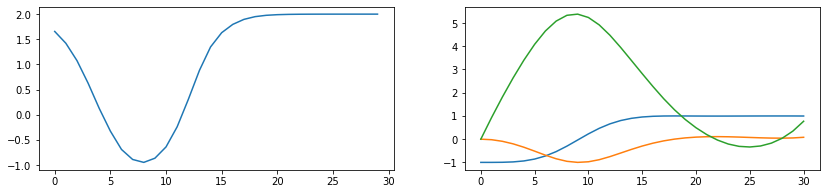

iteration 0 accepted 110.3370717322717 [-0.45925935  0.77632779] [1.24166167 0.97366633]
iteration 1 accepted 97.51218362475478 [-0.14347624  0.81998348] [1.40825911 1.12730882]
iteration 2 accepted 95.80712692345185 [-0.0655867   0.80233872] [1.45413035 1.16734773]
iteration 3 accepted 92.49328762215417 [0.02872008 0.78326559] [1.41306707 1.14488616]
iteration 4 accepted 91.695195080399 [0.06529946 0.77032554] [1.41695505 1.17329371]
iteration 5 accepted 91.38948267228638 [0.05354943 0.77153146] [1.49026559 1.25895487]
iteration 6 accepted 91.2843494512238 [0.05961609 0.77029276] [1.57362831 1.34245751]
iteration 7 accepted 91.23707908745845 [0.06210098 0.7694903 ] [1.63024522 1.39734566]
iteration 8 accepted 91.22194305301397 [0.06186221 0.76933527] [1.66580388 1.43181043]
iteration 9 converged 91.21892454775441 [0.0647882  0.76877689] [1.68783659 1.45321306]
40


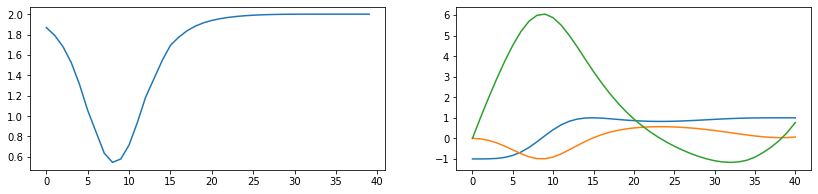

iteration 0 accepted 133.6371355221869 [-0.52477102  0.75194001] [1.6363395  1.41958949]
iteration 1 accepted 116.15777937842569 [-0.13147884  0.66828901] [1.67111806 1.4625182 ]
iteration 2 accepted 111.17038604407396 [-0.02184549  0.80217075] [1.72678107 1.51955096]
iteration 3 accepted 108.66079865011605 [0.07352106 0.77063859] [1.75623647 1.55129135]
iteration 4 accepted 108.27391543530855 [0.05910433 0.76889479] [1.7968471  1.59796164]
iteration 5 accepted 108.2276201844465 [0.06208057 0.76805353] [1.83195594 1.62768748]
iteration 6 accepted 108.21676954187885 [0.06652312 0.76740944] [1.8406648  1.63473648]
iteration 7 converged 108.21464918934787 [0.06745145 0.76721847] [1.84128191 1.63516217]
50


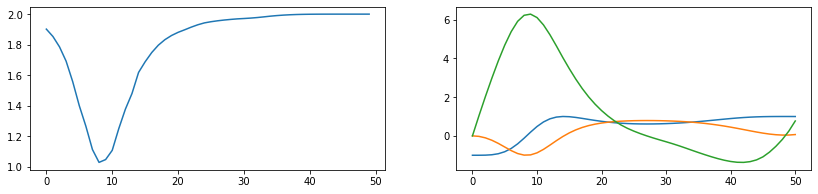

iteration 0 accepted 147.95672751458878 [-0.50107463  0.74199224] [1.8275238  1.62490942]
iteration 1 accepted 131.59853027746078 [-0.11949822  0.68024981] [1.82914652 1.62817313]
iteration 2 accepted 126.4416605964064 [0.00506149 0.78920621] [1.83477447 1.63390461]
iteration 3 accepted 125.08992089579792 [0.07256826 0.76880682] [1.83576525 1.63583919]
iteration 4 accepted 124.87846474375256 [0.05906436 0.7688579 ] [1.83919008 1.64038227]
iteration 5 accepted 124.8482497304894 [0.06174969 0.76808941] [1.84167087 1.64293046]
iteration 6 accepted 124.8352326068069 [0.06613688 0.76743329] [1.8434814  1.64492363]
iteration 7 converged 124.83265334671232 [0.0671568  0.76721466] [1.84302639 1.64413534]
60


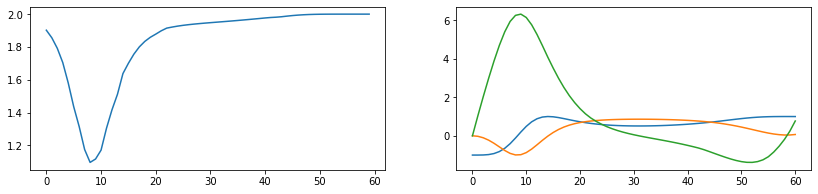

iteration 0 accepted 172.9588050981126 [-0.59141966  0.74819958] [1.8398204  1.64257646]
iteration 1 accepted 149.44096625364546 [-0.14746192  0.67295164] [1.84079021 1.64322202]
iteration 2 accepted 144.77456168419553 [-0.0392381   0.81596613] [1.84122811 1.6438726 ]
iteration 3 accepted 141.79614138537144 [0.06970254 0.7717393 ] [1.84206201 1.6448496 ]
iteration 4 accepted 141.49575145424225 [0.06002535 0.76894546] [1.84258581 1.64572537]
iteration 5 accepted 141.44388268163064 [0.06057539 0.76830775] [1.84485459 1.6483705 ]
iteration 6 accepted 141.4241083700521 [0.06539193 0.76756191] [1.84685402 1.65039084]
iteration 7 converged 141.42037142163713 [0.06661282 0.76731098] [1.84824241 1.65179637]
70


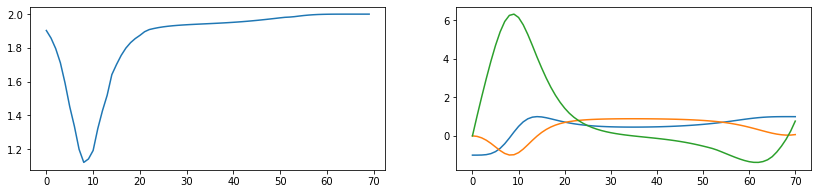

iteration 0 accepted 176.3418005312873 [-0.41958846  0.68311739] [1.84743105 1.65153606]
iteration 1 accepted 164.49273379983833 [-0.13114752  0.813591  ] [1.84781427 1.65147765]
iteration 2 accepted 160.7656443717511 [-0.02576511  0.80151856] [1.84746366 1.65123768]
iteration 3 accepted 158.3243533139671 [0.07096565 0.77110159] [1.84765163 1.65145619]
iteration 4 accepted 158.05977823178975 [0.05743013 0.76914632] [1.84777942 1.65176657]
iteration 5 accepted 158.0059341448403 [0.06653951 0.76762354] [1.8481078  1.65213527]
iteration 6 accepted 157.992952610854 [0.06614404 0.76738966] [1.84839358 1.65246571]


KeyboardInterrupt: 

In [28]:
np.random.seed(0)
us_init = np.random.uniform(-1, 1, (start_N, dynamics.action_size))

cur_x0 = x0
cur_us = us_init
for N in np.arange(start_N, total_N+1, partial_N):
    # Generate the optimiser and initial guess
    ilqr = iLQR(dynamics, cost, N)
    xs, us = ilqr.fit(x0, cur_us, n_iterations=500, on_iteration=on_iteration, tol=1e-2)
    
    if N == total_N:
        break

    new_us = np.random.uniform(-1, 1, (partial_N, dynamics.action_size))
    cur_us = np.vstack([us, new_us])
    
    print(N)
    
    fig = plt.figure(figsize=(14, 3))
    plt.subplots_adjust(hspace=0.4)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(constrain(us, -2, 2))
    ax2.plot(xs)
    plt.show()

In [ ]:
xs_recover = PendulumDynamic.reduce_state(xs)
us_constrain = constrain(us, -2.,  2.)

t = np.arange(N) * dt
theta = np.unwrap(xs_recover[:, 0])  # Makes for smoother plots.
theta_dot = xs_recover[:, 1]

In [ ]:
plt.plot(t, us)
plt.show()
plt.plot(t, us_constrain)
plt.show()

In [ ]:
obs0, _ = env.reset(init_state)
action = us_constrain[0]

all_obs = []
all_obs.append(obs0)
for i in range(total_N):
    next_obs, reward, done, info = env.step(us_constrain[i])
    all_obs.append(next_obs)
env.close()

In [ ]:
plt.plot(all_obs, 'r--')
plt.plot(xs)
plt.show()

# Step in the env by one step

In [ ]:
# one step in env
obs0, _ = env.reset(init_state)

In [ ]:
print(us.shape)

In [ ]:
next_obs, reward, done, info = env.step(us_constrain[0])

In [ ]:
print(next_obs)
print(xs[1])
# Small difference between prediction and estimation

In [ ]:
total_N

In [ ]:
xs[0]

In [ ]:
# optimise again
steps = 1
print(xs[1, :])
print(next_obs)
test = xs[1, :].copy()
test[1] += 0.01
test[2] += 0.01
print(test)

In [ ]:
ilqr = iLQR(dynamics, cost, 50)
xs1, us1 = ilqr.fit(test, us[1:51], n_iterations=100, on_iteration=on_iteration, tol=1e-2)

In [ ]:
plt.plot(t[1:51], us1)
plt.plot(t, us ,'r--', alpha=0.5)

In [ ]:
horizon = 10
all_obs = []
all_action = []

obs0, _ = env.reset(init_state)
action = us_constrain[0]
cur_obs = obs0
all_obs.append(cur_obs)

dynamics.min_bound = -2
dynamics.max_bound = 2

for i in range(total_N-1-horizon):
    cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=xs[i+horizon])
    ilqr = iLQR(dynamics, cost, horizon)
    next_xs, next_us = ilqr.fit(cur_obs, us[i:i+horizon], n_iterations=100, on_iteration=on_iteration, tol=1e-2)
    
    action =  constrain(next_us, -2., 2.)[0]
    
    next_obs, reward, done, info = env.step(action)
    env.render()
    
    print(next_xs[-1], next_obs)
    
    # Plot here
    fig = plt.figure(figsize=(14, 3))
    plt.subplots_adjust(hspace=0.4)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.plot(t, us_constrain, 'r--')  # Ref action
    ax1.plot(t[i: i+horizon],
             constrain(next_us, -2., 2.)[:, 0],
             'x-')  # On going optimisatoin
    
    ax2.plot(t, xs[1:], 'r--')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 0], 'bx-')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 1], 'yx-')  # Ref traj
    ax2.plot(t[i: i+horizon], next_xs[1:, 2], 'gx-')  # Ref traj
    plt.show()
    
    all_obs.append(cur_obs)
    all_action.append(action)
    cur_obs = next_obs
    
env.close()

In [2]:
data = torch.load('data/lagODE_mpc_ilqr_pendulum.pt')

In [7]:
for key in data:
    print(key)

all_obs
all_pred
all_pred_us
all_info
all_u


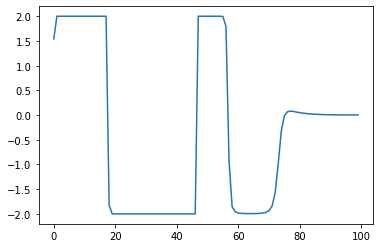

In [9]:
plt.plot(data['all_u'])

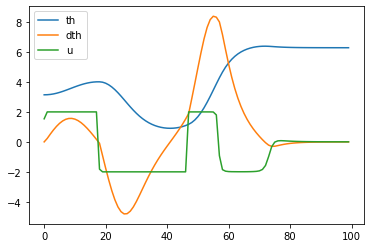

In [25]:
test = np.array(data['all_obs'])
plt.plot(np.unwrap(np.arctan2(test[:, 1], test[:, 0])), label='th')
plt.plot(test[:, 2], label='dth')
plt.plot(data['all_u'], label='u')
plt.legend()

Text(0.5, 0, 'th')

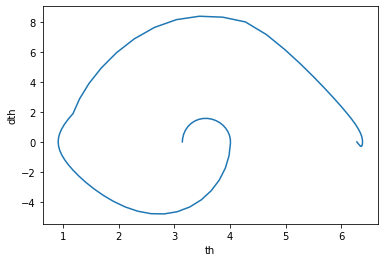

In [28]:
plt.plot(np.unwrap(np.arctan2(test[:, 1], test[:, 0])), test[:, 2])
plt.ylabel('dth')
plt.xlabel('th')